# Classification challenge - Ryan Moussouni

Problem is introduced here :
https://ibb.co/n7f1YrS

## Packages and Data Loading

In [0]:
#Standard packages
import numpy as np
import matplotlib.pyplot as plt
from time import time
#Debugguer 
from pdb import set_trace
#Sklearn packages
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict,StratifiedKFold
from sklearn.decomposition import PCA,KernelPCA
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#Data Processing
import pandas as pd
import seaborn as sns
from scipy.special import softmax
#Resampling
from imblearn.under_sampling import RandomUnderSampler,TomekLinks,EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD
print(tf.__version__)

2.2.0-rc3


In [0]:
#### Uploading data
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1wMJSXrkxDgL1gqq8cf9CCdITihJzXYAX'
xtrain_file = drive.CreateFile({'id': file_id})
file_id = '14LYANr0EYN3lysvUDvOZgf0qsyMGkyrb'
ytrain_file = drive.CreateFile({'id': file_id})
file_id = '1FsKEdcPhQAQxzn7kACl3iS8u-phDCI3L'
xtest_file = drive.CreateFile({'id': file_id})

In [0]:
#### Getting xtrain using numpy
xtrain_file.GetContentFile('xtrain_challenge.csv')  
xtrain = np.loadtxt('xtrain_challenge.csv', delimiter=',', skiprows = 1)

In [0]:
#### Getting xtrain using pandas
xtrain_file.GetContentFile('xtrain_challenge.csv')  
x_train = pd.read_csv('xtrain_challenge.csv')

In [0]:
#### Getting ytrain
ytrain_file.GetContentFile('ytrain_challenge.csv')  
ytrain = np.loadtxt('ytrain_challenge.csv', delimiter=',', skiprows = 1)

In [0]:
#### Getting test file
xtest_file.GetContentFile('xtest_challenge.csv')  
x_test = pd.read_csv('xtest_challenge.csv')

In [0]:
#Checking class balance
print("Number of faces recognized : %i Number of faces not recognized %i" %(np.sum(ytrain), np.sum(1-ytrain)))
print("Data is heavily imbalanced")

Number of faces recognized : 39593 Number of faces not recognized 1028911
Data is heavily imbalanced


## Data Visualization

### First features

In [0]:
#Let's see what it looks like
def feature_engineering(resampling = False, scaling = False):
    '''
    Desc :
    feat_a and feat_b are the features of the 2 pictures
    
    Inputs :
    resampling consists in undersampling the majority class using RUS
    scaling checks the effects of scaling on data repartition
    '''
    if resampling:
      ros = RandomUnderSampler()
      xtemp, ytemp = ros.fit_resample(xtrain,ytrain)
      feat_a = xtemp[:,:13]
      feat_b = xtemp[:,13:26]
    if scaling:
      scaler = StandardScaler()
      xtemp = scaler.fit_transform(xtrain)
      feat_a = xtemp[:,13]
      feat_b = xtemp[:,13:26]
    else :
      xtemp = xtrain.copy()
      ytemp = ytrain.copy()
      feat_a = xtemp[:,:13]
      feat_b = xtemp[:,13:26]
    return np.concatenate((feat_a,feat_b),axis = 1)[ytemp == 0],np.concatenate((feat_a,feat_b),axis = 1)[ytemp == 1]



In [0]:
#Histograms of the features
def histo(i, n_bins,resampling=False, scaling=False):
    classe0 = pd.DataFrame(feature_engineering(resampling,scaling)[0])
    classe1 = pd.DataFrame(feature_engineering(resampling, scaling)[1])
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plt.suptitle("Histogram of the feature: " + str(i) ,size = 16, weight = 'semibold')
    ax[0].hist(classe0[i],n_bins,color= 'red',edgecolor = 'black')
    ax[0].set_xlabel("values")
    ax[0].set_title("classe 0")
    ax[1].hist(classe1[i],n_bins,color= 'blue', edgecolor = 'black')
    ax[1].set_xlabel("values")
    ax[1].set_title("classe 1")
    plt.show()
    return

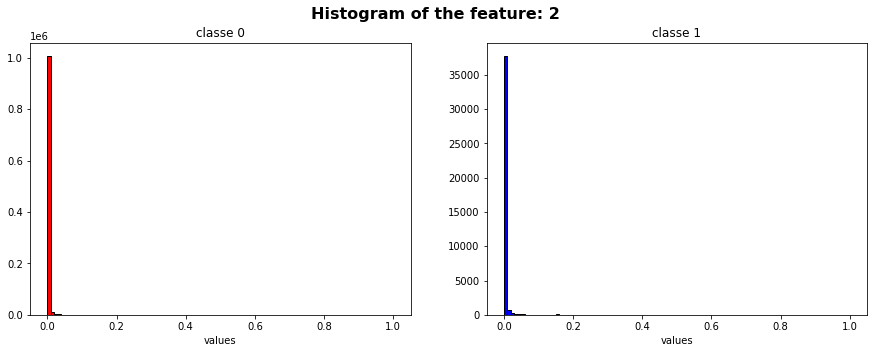

In [0]:
histo(2,100) 

In [0]:
#Histograms of the features
def histo(i,h,resampling=False, scaling=False):
    classe0 = pd.DataFrame(feature_engineering(True,False)[0])
    classe1 = pd.DataFrame(feature_engineering(True, False)[1])
    plt.scatter(classe0[i],classe0[i+h],color= 'red')
    plt.scatter(classe1[i],classe1[i+h],color= 'blue')
    plt.show()
    return

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


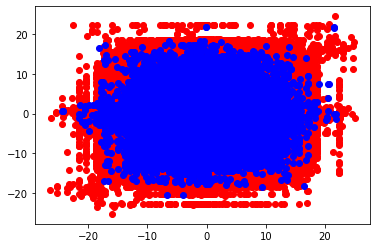

Impossible to **dinstinguish classes** from the first features as it is : high **overlap**.

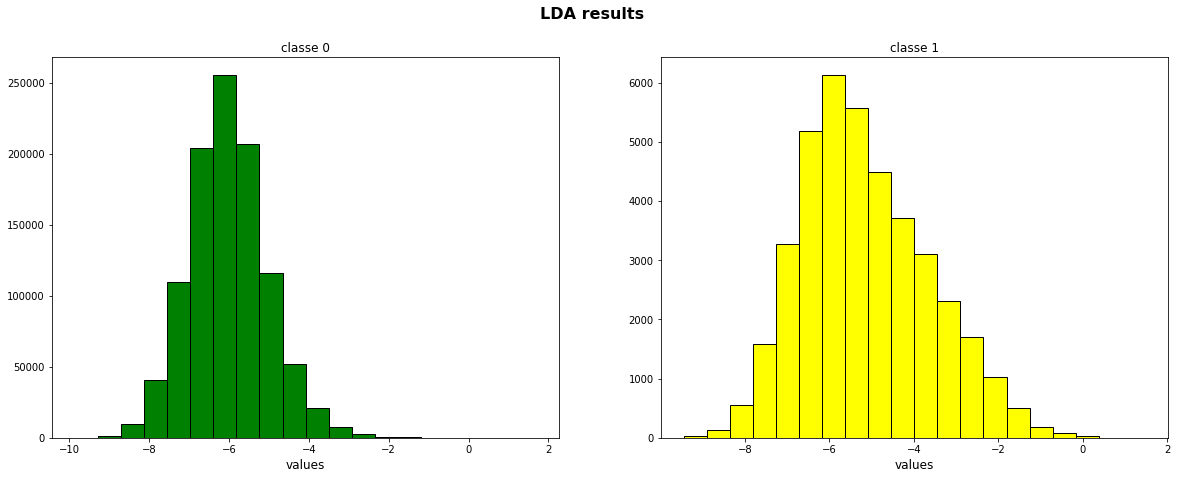

In [0]:
#Let's try some Linear Discriminant Analysis to try separating the two groups
#Preprocessing using LDA
lda = LinearDiscriminantAnalysis(solver = 'eigen',shrinkage = 'auto')
processed_data = lda.fit_transform(xtrain[:,:26],ytrain)

#Plotting results
n_bins = 20
fig,ax = plt.subplots(1,2, figsize = (20,7))
plt.suptitle("LDA results",size = 16, weight = 'semibold')
ax[0].hist(processed_data[ytrain==0],n_bins,color= 'green',edgecolor = 'black')
ax[0].set_xlabel("values",size = 'large')
ax[0].set_title("classe 0",size = 'large')
ax[1].hist(processed_data[ytrain==1],n_bins,color= 'yellow', edgecolor = 'black')
ax[1].set_xlabel("values",size = 'large')
ax[1].set_title("classe 1",size = 'large')
plt.show()

That's it we won't be able to get more than this, out of the first features. There still is a high overlap between the two classes. And because there is an overwhelming majority of samples in the negative class, our classification algorithms on such data are very likely to put every prediction to zero to maximize accuracy.

### Scores

In [0]:
##Let's see what the scores look like
def feature_engineering_sc(resampling = False, scaling = False):
    '''
    Desc :
    fscores are the scores computed from the 2 pictures
    
    Inputs :
    resampling consists in undersampling the majority class using RUS
    scaling checks the effects of scaling on data repartition
    '''
    if resampling:
      ros = RandomUnderSampler()
      xtemp, ytemp = ros.fit_resample(xtrain,ytrain)
      scores = xtemp[:,26:]
    if scaling:
      scaler = StandardScaler()
      xtemp = scaler.fit_transform(xtrain)
      scores = xtemp[:,26:]
    else :
      xtemp = xtrain.copy()
      ytemp = ytrain.copy()
      scores = xtrain[:,26:]
    return scores[ytemp == 0],scores[ytemp == 1]

def histo_sc(i, n_bins,resampling=False,scaling=False):
    classe0_score = pd.DataFrame(feature_engineering_sc(resampling,scaling)[0])
    classe1_score = pd.DataFrame(feature_engineering_sc(resampling,scaling)[1])
    n_bins = 100
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plt.suptitle("Score " + str(i) + " for the classes",size = 16, weight = 'semibold')
    ax[0].hist(classe0_score[i],n_bins,color= 'red',edgecolor ='black')
    ax[0].set_xlabel("Score")
    ax[0].set_title("classe 0")
    ax[1].hist(classe1_score[i],n_bins,color= 'blue',edgecolor = 'black')
    ax[1].set_xlabel("Score")
    ax[1].set_title("classe 1")
    plt.show()
    return

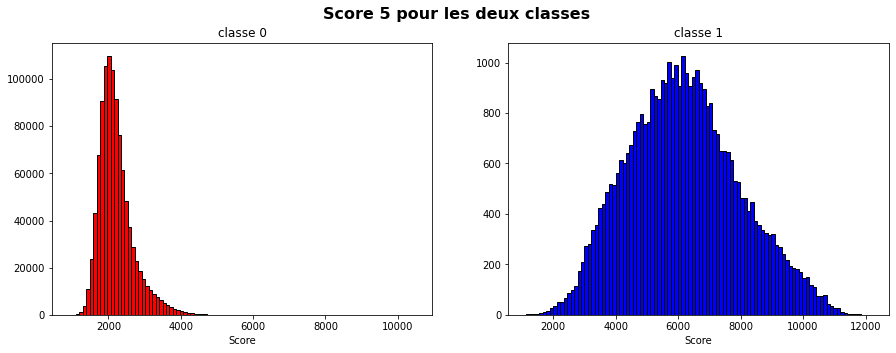

In [0]:
histo_sc(5,100)

**Conclusion** : The data from the scores are way cleaner and seem to be able to be classified correctly using a linear classifier such as an SVM. Yet, it seems  to remain some overlapping data between the two classes. We might not be able to get a great accuracy score from out of these data only. 

## Good Results on score using SVM 



We try to classify the data using only the scores and an SVM, to get experimental validation of our thoughts. Because the SVM computational time on the whole data set is high, we undersample the majority class first.

In [0]:
##Preprocessing
#Splitting data
xxtrain, xxtest, yytrain, yytest = train_test_split(xtrain, ytrain, test_size = 0.2)

#Random UnderSampling
ros = RandomUnderSampler()
xxtrain_ros, yytrain_ros = ros.fit_sample(xxtrain, yytrain)
#Tomek Links
undersample = TomekLinks()
xxtrain_tl, yytrain_tl = undersample.fit_resample(xxtrain_ros, yytrain_ros)
#Checking proportions
print('Class balance', np.sum(yytrain_tl)/len(yytrain_tl),np.sum(yytrain_ros)/len(yytrain_ros),np.sum(yytrain)/len(yytrain), np.sum(yytest)/len(yytest),np.sum(ytrain)/len(ytrain)) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class balance 0.4992886275253723 0.5 0.03705415165833531 0.037056448027852 0.03705461093266848


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### Best SVM

In [0]:
## Getting the SVM and confusion matrix
t = time()
svm_est = svm.SVC(kernel = 'linear', C =  300, class_weight= {0 : 0.96 , 1 : 0.04}) #hyper parameters have been obtained using CrossValidation, not shown here
svm_est.fit(xxtrain_tl, yytrain_tl) #fitting on resampled data

print("Computing time %f s" %(time() -t))

#Getting predictions 
yytrain_pred = svm_est.predict(xxtrain_tl)
yytest_pred = svm_est.predict(xxtest)

#Computing confusion matrix 
conf_mat0 = confusion_matrix(y_true=yytrain_tl, y_pred=yytrain_pred) #results of the train
print('Train Confusion matrix:\n', conf_mat0)
conf_mat1 = confusion_matrix(y_true=yytest, y_pred=yytest_pred) #checking on imbalanced data
print('Test Confusion matrix:\n', conf_mat1)

#Score 
print('Score %f' %svm_est.score(xxtest,yytest))

Computing time 544.159127 s
Train Confusion matrix:
 [[31658    16]
 [ 1073 30511]]
Test Confusion matrix:
 [[205634    148]
 [   294   7625]]
Score 0.997932


As we can see, SVM show good results on our split using only the scores. In fact these results are just the ones of the algorithms you used on the image. 


## How to do the fusion ?


Now question is : how can we get better results by **using data of the first features** ? 

A first idea I had was to try to **process the scores and the first features separetly**, to classify them using two different classifiers each adapted to each data set. Then I would merge the results by taking into account **confidence scores** on each of the two prediction. A huge drawback to this technique is that, as we saw, **on its own, the data set of the first features is not usable**. Therefore one of the classifier would totally fail at predicting anything but zeros. 

A good idea is to **extend the dimensions of the data set of the first features** by incorporating the data on the score. That's in fact a natural idea when you see *xtrain*. Why would it yield better results ? We could understand it if we thought in 3 dimensions. 

Let's say you have a 2 D data set with overlapping data from 2 classes, and you add a third dimension with new information on these 2 classes. The overlapping data in the first 2 D plane could be separated thanks to this new information, and the ovelapping data in the new axis wouldn't be a problem because it could be separated thanks to a projection on the plane.

To be able to do such a classification you need a new classifier that's not linear and good with high dimensions. SVM is out of question whatever the kernel might be. Neural Networks are not suited for these kind of problems, therefore I choose to use Trees. After trying and testing results Basic Trees and Random Forest don't yield good results. Therefore I used **boosted trees** and **XGB** (and also because I heard it is used to winning data classification contests to be quite honest ahah)

## Final Results

In [0]:
##Preprocessing
#Scaling
#I use pandas to process the data as numpy seems to fail with xtest
mean = x_train.mean()
std = x_train.std()
x_train_ft=(x_train-mean)/std
mean = x_test.mean()
std = x_test.std()
x_test_ft = (x_test-mean)/std

In [0]:
interaction_constraints = []
for i in range(13):
  interaction_constraints.append([i,i+13])
interaction_constraints.append([26 + k for k in range(11)])

In [0]:
interaction_constraints

[[0, 13],
 [1, 14],
 [2, 15],
 [3, 16],
 [4, 17],
 [5, 18],
 [6, 19],
 [7, 20],
 [8, 21],
 [9, 22],
 [10, 23],
 [11, 24],
 [12, 25],
 [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]]

In [0]:
model = XGBClassifier(scale_pos_weight = 27.4,learning_rate =0.03, n_estimators=1300, max_depth=12,
min_child_weight=4, gamma=0.1, subsample=0.65, colsample_bytree=0.7, reg_alpha = 0.1,
objective= 'binary:logistic', nthread=4,seed=27,tree_method = 'gpu_hist',interaction_constraints = interaction_constraints,early_stopping_rouds = 10,eval_metric = 'auc') #I used cross validation by hand to tune hyperparameters

In [0]:
cross_val_score(model,x_train_ft,ytrain)

array([0.99879739, 0.9989986 , 0.99902668, 0.99912963, 0.99901263])

In [0]:
StratifiedKFold(model,x_train_ft,ytrain)

ValueError: ignored

[0]	validation_0-error:0.004643	validation_0-logloss:0.664014	validation_1-error:0.005723	validation_1-logloss:0.66407
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.003047	validation_0-logloss:0.636487	validation_1-error:0.003837	validation_1-logloss:0.636589
[2]	validation_0-error:0.003168	validation_0-logloss:0.637274	validation_1-error:0.00555	validation_1-logloss:0.665623
[3]	validation_0-error:0.00279	validation_0-logloss:0.610555	validation_1-error:0.003233	validation_1-logloss:0.58619
[4]	validation_0-error:0.002904	validation_0-logloss:0.612555	validation_1-error:0.003285	validation_1-logloss:0.563004
[5]	validation_0-error:0.002156	validation_0-logloss:0.541583	validation_1-error:0.002971	validation_1-logloss:0.541875
[6]	validation_0-error:0.002509	validation_0-logloss:0.56518	validation_1-error:0.003074	validation_1-logloss:0.521082


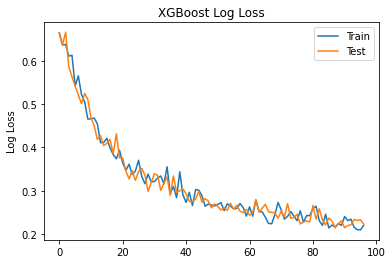

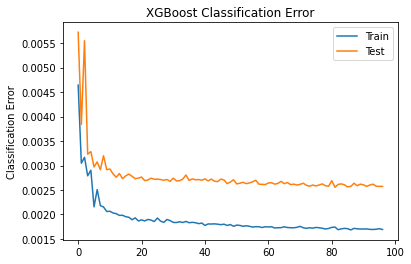

In [0]:
## Check for overfitting;  I found the code on the Internet
from sklearn.metrics import accuracy_score
xxtrain, xxtest,yytrain,yytest = train_test_split(xtrain,ytrain,test_size = 0.2)
eval_set = [(xxtrain, yytrain), (xxtest, yytest)]
model.fit(xxtrain, yytrain, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True,early_stopping_rounds= 10)
# make predictions for test data
y_pred = model.predict(xxtest)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(yytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [0]:
model.fit(x_train_ft,ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, early_stopping_rouds=10,
              eval_metric='auc', gamma=0.1,
              interaction_constraints=[[0, 13], [1, 14], [2, 15], [3, 16],
                                       [4, 17], [5, 18], [6, 19], [7, 20],
                                       [8, 21], [9, 22], [10, 23], [11, 24],
                                       [12, 25],
                                       [26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                                        36]],
              learning_rate=0.03, max_delta_step=0, max_depth=12,
              min_child_weight=4, missing=None, n_estimators=1300, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=27.4, seed=27,
              silent=None, subsample=0.65, tree_method='gpu_hist', verbosity=1)

In [0]:
print('Importance of the scores in the classification : %f' %(np.sum(model.feature_importances_[26:])/np.sum(model.feature_importances_)))

Importance of the scores in the classification : 0.946043


In [0]:
ytest = model.predict(x_test_ft)

In [0]:
np.sum(1-ytest)/len(ytest)

0.9646845851003045

In [0]:
from google.colab import files
np.savetxt('ytest_challenge_student.csv', ytest, fmt = '%1.0d', delimiter=',')
files.download('ytest_challenge_student.csv') 

## Further improvements

I did not use any preprocessing technique on the data so basically they are very 'raw'. They could use some, but quite frankly I wouldn't know what to do. I tried some PCA on the first features but it didn't show any improvement. LDA neither. Other than that I could try tuning the hyperparameters better on XGB by implementing a grid search instead of doing it by hand but it's really time consuming.